In [1]:
import pandas as pd
import numpy as np

DATA_SOURCE = "https://gitee.com/chenyulue/data_samples/raw/main/wow/EU27_population_2015-2024.CSV"

data_df = pd.read_csv(DATA_SOURCE, dtype_backend="pyarrow")

In [2]:
data_df.head()

,Country,Year,Age,Male,Female
0,Belgium,2015,Less than 1 year,64029,60774
1,Belgium,2015,1 year,64555,61532
2,Belgium,2015,2 years,65969,63394
3,Belgium,2015,3 years,66985,63914
4,Belgium,2015,4 years,68142,65119


In [3]:
import numpy as np

ages = data_df["Age"].str.extract(r"(?P<age>\d+)").astype(int)
age_rank = np.where(ages < 15, "Young", np.where(ages < 65, "Active population", "Elders"))

population_total = data_df.loc[:, ["Country", "Year", "Male", "Female"]] \
    .groupby(["Country", "Year"]).sum().sum(axis=1) \
        .reset_index().reset_index().rename(columns={0: "Total"})

data_df_total = data_df.merge(population_total, on=["Country", "Year"])
data_df_total = data_df_total.assign(
    Age_Rank=age_rank,
    Male_Ratio=data_df_total["Male"] / data_df_total["Total"],
    Female_Ratio=data_df_total["Female"] / data_df_total["Total"],
)
data_df_total.head()

,Country,Year,Age,Male,Female,index,Total,Age_Rank,Male_Ratio,Female_Ratio
0,Belgium,2015,Less than 1 year,64029,60774,10,11237274,Young,0.005698,0.005408
1,Belgium,2015,1 year,64555,61532,10,11237274,Young,0.005745,0.005476
2,Belgium,2015,2 years,65969,63394,10,11237274,Young,0.005871,0.005641
3,Belgium,2015,3 years,66985,63914,10,11237274,Young,0.005961,0.005688
4,Belgium,2015,4 years,68142,65119,10,11237274,Young,0.006064,0.005795


In [4]:
import plotly.graph_objects as go

Country1 = "Belgium"
Country2 = "Austria"

Year1 = 2024
Year2 = 2024

data_filtered = data_df_total.query("Country == @Country1 and Year == @Year1")
data_filtered_ref = data_df_total.query("Country == @Country2 and Year == @Year2")

female_colors = {
    "Elders": "#c46487",
    "Active population": "#D18EB0",
    "Young": "#DBB5D3",
}
male_colors = {
    "Elders": "#27aab0",
    "Active population": "#60BEBC",
    "Young": "#96D0C7",
}
line_color = "#632538"
grid_color = "#F2F2F2"

x_range = np.arange(-1, 1.1, 0.1) / 100

data_custom = pd.concat([
    data_filtered.reset_index(drop=True), 
    data_filtered_ref.reset_index(drop=True).rename(columns=lambda x: f"{x}2")
    ], axis=1)

hover_template = ("%{customdata[2]} <br>"
                  "(%{customdata[7]})<br><br>"
                  "<span style='fontsize:12px;font-weight:bold'>%{customdata[0]} - %{customdata[1]}</span><br>"
                  "<span style='color:#c46487'>Female</span>: %{customdata[4]:,}<br>"
                  "%{customdata[9]:.1%} of total population<br>"
                  "<span style='color:#27aab0'>Male</span>: %{customdata[3]:,}<br>"
                  "%{customdata[8]:.1%} of total population<br><br>"
                  "<span style='fontsize:12px;font-weight:bold'>%{customdata[10]} - %{customdata[11]}</span><br>"
                  "<span style='color:#c46487'>Female</span>: %{customdata[14]:,}<br>"
                  "%{customdata[19]:.1%} of total population<br>"
                  "<span style='color:#27aab0'>Male</span>: %{customdata[13]:,}<br>"
                  "%{customdata[18]:.1%} of total population<br><br>"
                  "<extra></extra>")

fig = go.Figure()
fig.add_traces([
    go.Bar(
        name="Female",
        x=data_filtered["Female_Ratio"],
        y=data_filtered["Age"],
        orientation="h",
        marker=dict(
            color=[female_colors[age] for age in data_filtered["Age_Rank"]],
        ),
        showlegend=False,
        customdata=data_custom,
        hovertemplate=hover_template,
        hoverlabel=dict(
            bgcolor="white",
        )
    ),
    go.Bar(
        name="Male",
        x=-data_filtered["Male_Ratio"],
        y=data_filtered["Age"],
        orientation="h",
        marker=dict(
            color=[male_colors[age] for age in data_filtered["Age_Rank"]],
        ),
        showlegend=False,
        customdata=data_custom,
        hovertemplate=hover_template,
        hoverlabel=dict(
            bgcolor="white",
        )
    ),
    go.Scatter(
        x=data_filtered_ref["Female_Ratio"],
        y=data_filtered_ref["Age"],
        mode="lines",
        line=dict(
            color=line_color,
        ),
        showlegend=False,
        customdata=data_custom,
        hovertemplate=hover_template,
        hoverlabel=dict(
            bgcolor="white",
        )
    ),
    go.Scatter(
        x=-data_filtered_ref["Male_Ratio"],
        y=data_filtered_ref["Age"],
        mode="lines",
        line=dict(
            color=line_color,
        ),
        showlegend=False,
        customdata=data_custom,
        hovertemplate=hover_template,
        hoverlabel=dict(
            bgcolor="white",
        )
    )
])

fig.update_layout(
    width=1000,
    height=1000,
    barmode="relative",
    plot_bgcolor="white",
    xaxis=dict(
        range=[-1.01/100, 1.01/100],
        tickmode="array",
        tickvals=x_range,
        ticktext=[f"{abs(x):.1%}" if abs(x) >= 0.0001 else "" for x in x_range],
        ticks="",
        gridcolor=grid_color,
    ),
    yaxis=dict(
        ticks="",
        showticklabels=False,
        range=[-1, len(data_filtered)],
    ),
    margin=dict(
        t=120, b=80, l=10, r=10,
    )
)

fig.add_annotation(
    text="Male",
    showarrow=False,
    xref="x domain",
    x=0.25,
    xanchor="center",
    yref="y domain",
    y=0,
    yanchor="top",
    yshift=-20,
    font_weight="bold",
)

fig.add_annotation(
    text="Female",
    showarrow=False,
    xref="x domain",
    x=0.75,
    xanchor="center",
    yref="y domain",
    y=0,
    yanchor="top",
    yshift=-20,
    font_weight="bold",
)

fig.add_annotation(
    text=("Challenged by <span style='color:#27aab0'>Chenyu Lue</span> | "
          "Week 15 <span style='color:#27aab0'>#WorkoutWednesday</span> | "
          "Data: <span style='color:#27aab0'>EUROSTAT</span>"
    ),
    showarrow=False,
    xref="x domain",
    x=0.5,
    xanchor="center",
    yref="y domain",
    y=0,
    yanchor="top",
    yshift=-50,
)

fig.add_annotation(
    text=("<b>Male</b><br>"
          f"<b>{data_filtered['Country'].iloc[0]}-{data_filtered['Year'].iloc[0]}</b>  "
          f"<span style='color:{male_colors['Elders']}'>■</span> Elders<br>"
          f"<span style='color:{male_colors['Active population']}'>■</span> Active population "
          f"<span style='color:{male_colors['Young']}'>■</span> Young<br>"
          f"<b>{data_filtered_ref['Country'].iloc[0]}-{data_filtered_ref['Year'].iloc[0]}</b> "
          f"<span style='color:{line_color}'>─</span>"
    ),
    xref="x domain",
    x=0.25,
    xanchor="right",
    yref="y domain",
    y=1,
    yanchor="bottom",
    yshift=10,
    showarrow=False,
    align="center",
    bgcolor="#F5F5F5",
    width=200,
    height=80,
)
fig.add_annotation(
    text=("<b>Female</b><br>"
          f"<b>{data_filtered['Country'].iloc[0]}-{data_filtered['Year'].iloc[0]}</b>  "
          f"<span style='color:{female_colors['Elders']}'>■</span> Elders<br>"
          f"<span style='color:{female_colors['Active population']}'>■</span> Active population "
          f"<span style='color:{female_colors['Young']}'>■</span> Young<br>"
          f"<b>{data_filtered_ref['Country'].iloc[0]}-{data_filtered_ref['Year'].iloc[0]}</b> "
          f"<span style='color:{line_color}'>─</span>"
    ),
    xref="x domain",
    x=1,
    xanchor="right",
    yref="y domain",
    y=1,
    yanchor="bottom",
    yshift=10,
    showarrow=False,
    align="center",
    bgcolor="#F5F5F5",
    width=200,
    height=80,
)

fig.add_annotation(
    text=("Total Population<br>"
          f"<b>{data_filtered['Country'].iloc[0]}-{data_filtered['Year'].iloc[0]}</b>:<br><br>"
          f"<span style='font-size:18px'>{data_filtered['Total'].iloc[0]:,.0f}</span>"
    ),
    xref="x domain",
    x=0.5,
    xanchor="right",
    yref="y domain",
    y=1,
    yanchor="bottom",
    yshift=10,
    showarrow=False,
    align="center",
    bgcolor="#F5F5F5",
    width=200,
    height=80,
)
fig.add_annotation(
    text=("Total Population<br>"
          f"<b>{data_filtered_ref['Country'].iloc[0]}-{data_filtered_ref['Year'].iloc[0]}</b>:<br><br>"
          f"<span style='font-size:18px'>{data_filtered_ref['Total'].iloc[0]:,.0f}</span>"
    ),
    xref="x domain",
    x=0.75,
    xanchor="right",
    yref="y domain",
    y=1,
    yanchor="bottom",
    yshift=10,
    showarrow=False,
    align="center",
    bgcolor="#F5F5F5",
    width=200,
    height=80,
)

fig.show()

In [5]:
import altair as alt

In [6]:
yseq = data_filtered["Age"][::-1]
female_scale = alt.Scale(domain=list(female_colors.keys()), range=list(female_colors.values()))
male_scale = alt.Scale(domain=list(male_colors.keys()), range=list(male_colors.values()))

base = alt.Chart(data_filtered).properties(
    width=300, height=600,
)

left = base.mark_bar().encode(
    alt.Y("Age:N").axis(None).sort(yseq),
    alt.X("Male_Ratio:Q").sort("descending").title("Male"),
    alt.Color("Age_Rank:N").scale(male_scale)
)

right = base.mark_bar().encode(
    alt.Y("Age:N").axis(None).sort(yseq),
    alt.X("Female_Ratio:Q").title("Female"),
    alt.Color("Age_Rank:N").scale(female_scale)
)

alt.concat(left, right, spacing=0)

alt.ConcatChart(...)

Text(0.75, -0.03, 'Female')

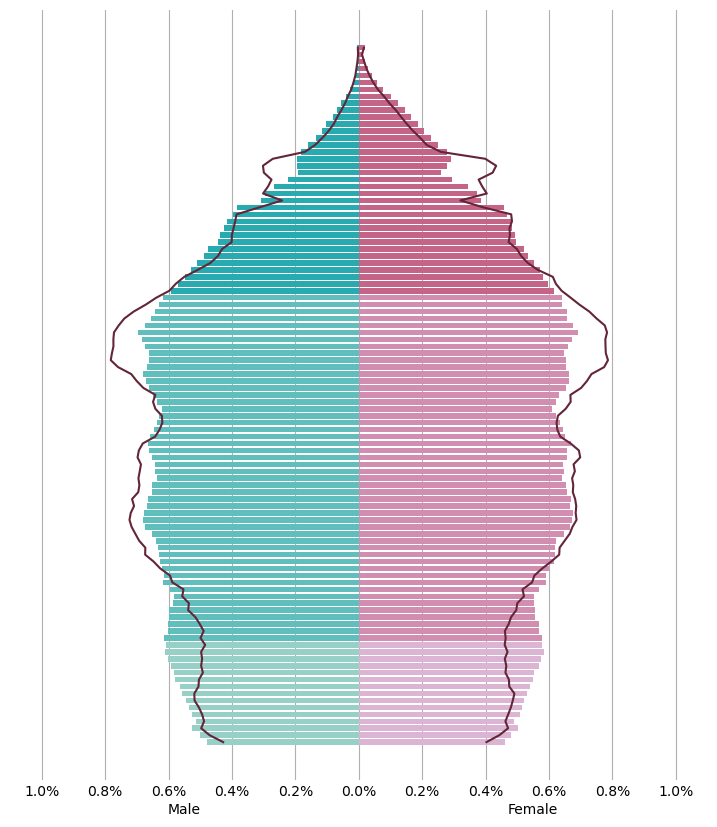

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(9, 10))

bar_right = ax.barh(
    data_filtered["Age"], data_filtered["Female_Ratio"],
    color=[female_colors[i] for i in data_filtered["Age_Rank"]],
)

bar_left = ax.barh(
    data_filtered["Age"], -data_filtered["Male_Ratio"],
    color=[male_colors[i] for i in data_filtered["Age_Rank"]],
)

line_right = ax.plot(
    data_filtered_ref["Female_Ratio"], data_filtered_ref["Age"],
    color=line_color,
)

line_left = ax.plot(
    -data_filtered_ref["Male_Ratio"], data_filtered_ref["Age"],
    color=line_color,
)

ax.spines[:].set_visible(False)
ax.set_yticks([])

ax.set_xticks(np.arange(-0.01, 0.011, 0.002))
ax.set_xticklabels([f"{abs(i):.1%}" for i in ax.get_xticks()])
ax.tick_params(axis="x", length=0)
ax.set_xlim(-0.011, 0.011)

ax.grid(True, axis="x")
ax.xaxis.set_zorder(0)

ax.text(0.25, -0.03, "Male", ha="center", va="top", transform=ax.transAxes)
ax.text(0.75, -0.03, "Female", ha="center", va="top", transform=ax.transAxes)

# fig.savefig("wow.png", dpi=300, bbox_inches="tight")


In [8]:
DATA_SOURCE = "./Sample-Superstore_Orders.csv"

data_df = pd.read_csv(DATA_SOURCE, dtype_backend="pyarrow")

In [24]:
profit_ratio_vs_sales = data_df.loc[:, ["State","Profit"]].assign(
    Sales=data_df["Sales"].str.replace(r",|\$","", regex=True).astype(np.float64)
).groupby("State").sum()

profit_ratio_vs_sales = profit_ratio_vs_sales.assign(
    Profit_Ratio=profit_ratio_vs_sales["Profit"] / profit_ratio_vs_sales["Sales"]
)

In [36]:
fig = go.Figure()

fig.add_traces([
    go.Scatter(
        mode="markers",
        x=profit_ratio_vs_sales["Sales"],
        y=profit_ratio_vs_sales["Profit_Ratio"],
        customdata=profit_ratio_vs_sales.reset_index(),
        hovertemplate=("<b>%{customdata[0]}</b><br><br>"
                       "<b>Profit Ratio:</b> %{customdata[3]:.0%}<br>"
                       "<b>Sales:</b> %{customdata[2]:.3s}<extra></extra>"
        ),
        hoverlabel=dict(
            bgcolor="white",
        ),
    )
])

fig.update_layout(
    width=600,
    height=450,
    yaxis=dict(
        range=[-0.4, 0.4]
    )
)

fig.show()

In [37]:
profit_ratio_vs_sales.quantile()

Profit          2196.1023
Sales             22207.0
Profit_Ratio     0.250163
Name: 0.5, dtype: double[pyarrow]